In [23]:
import pandas as pd
import numpy as np
import os

data_dir = './Data'

pd.set_option('display.max_rows', 150)

<b>Load data</b>

In [24]:
import geopandas as gpd

In [25]:
data_dir = './Data'
df = pd.read_csv(os.path.join(data_dir,'Trade_GDP_CalSuff.csv')).set_index('ISO3').drop(columns=['Unnamed: 0'])
df = df.rename({'GDP_ssp1_2010':'GDP_2010'},axis=1)
df['2013_Trade_Class'] = ""
df['2001_Trade_Class'] = ""

#0 = importer, 1 = medium 2 = exporter,
for ind in range(len(df)):
    if df['Trade_2013'][ind] < 0.1:
        df['2013_Trade_Class'][ind] = "Importer"
    elif df['Trade_2013'][ind] > 0.8:
        df['2013_Trade_Class'][ind] = "Exporter"
    else:
         df['2013_Trade_Class'][ind] = "Medium"
            
for ind in range(len(df)):
    if df['Trade_2001'][ind] < 0.1:
        df['2001_Trade_Class'][ind] = "Importer"
    elif df['Trade_2001'][ind] > 0.8:
        df['2001_Trade_Class'][ind] = "Exporter"
    else:
         df['2001_Trade_Class'][ind] = "Medium"

<ipython-input-25-47ff419173b1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2013_Trade_Class'][ind] = "Medium"
<ipython-input-25-47ff419173b1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2013_Trade_Class'][ind] = "Importer"
<ipython-input-25-47ff419173b1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2013_Trade_Class'][ind] = "Exporter"
<ipython-input-25-47ff419173b1>:22: SettingWithCopyWarning: 
A value is try

# Modelling 2050 Trade Index Based on different years of past trade Index(2013, 2001, 1998)

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [27]:
df['log_GDP_2010'] = df['GDP_2010'].apply(lambda x:np.log(x))
df = df.dropna()

In [6]:
def randForClass_2001():
    X = df[['Calsuff_2000','log_GDP_2010']]  
    y = df['2001_Trade_Class'] 

    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state = 0)
    print(y_train)
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    # Train and Test Accuracy
    print("Train Accuracy :: ", accuracy_score(y_train, rf.predict(X_train)))
    print("Test Accuracy  :: ", accuracy_score(y_test, y_pred))
    print(rf.get_params())
    print()
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
    print(random_grid)
    
    from sklearn.model_selection import RandomizedSearchCV
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    print("Best Params: ",rf_random.best_params_)
    
    best_random = rf_random.best_estimator_
    y_pred = best_random.predict(X_test)
    print("BP Train Accuracy :: ", accuracy_score(y_train, best_random.predict(X_train)))
    print("BP Test Accuracy  :: ", accuracy_score(y_test, y_pred))

    for i in np.arange(1,6):
        df['log_GDP_ssp'+str(i)] = df['GDP_ssp'+str(i)].apply(lambda x:np.log(x))
        
    for i in np.arange(1,6):
        df['Trade_lm_predicted_ssp'+str(i)] = best_random.predict(df[['Calsuff_ssp'+str(i),'log_GDP_ssp'+str(i)]])
        
    df['Repredicted_2001'] = best_random.predict(df[['Calsuff_2000','log_GDP_2010']])
    
    from datetime import datetime

    # datetime object containing current date and time
    now = datetime.now()
    
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    file_name = 'TI_Table_'+dt_string+'.csv'
    df.to_csv(file_name)
        
    import geopandas
    import matplotlib.pyplot as plt
    import matplotlib.colors
    import matplotlib.patches as mpatches
    
    #import geoplot

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world.set_index("iso_a3").merge(df)
    
    # Colormap
    colorsList = [ '#3b61e9','#815abb', '#c4c4c4']
    im = mpatches.Patch(color='#815abb', label='Importer')
    med = mpatches.Patch(color='#c4c4c4', label='Medium')
    ex = mpatches.Patch(color='#3b61e9', label='Exporter')
    
    cmap = matplotlib.colors.ListedColormap(colorsList)
    fig, axes = plt.subplots(nrows=4,ncols=2, figsize=(20, 10))
    plt.subplots_adjust(left=0.4, bottom=0.2, right=0.99, top=1.15)

    world.plot(column='Trade_lm_predicted_ssp1', cmap=cmap, linewidth=0.8, ax=axes[0,0])#, edgecolor=’0.8')
    axes[0,0].legend(handles=[im, med, ex], bbox_to_anchor=(1.19, 0.8))

    axes[0,0].set_title('Approximated trade status in 2050 (SSP1)', fontdict={'fontsize':'16'});
    axes[0,0].axis('off');

    world.plot(column='Trade_lm_predicted_ssp2', cmap=cmap, linewidth=0.8, ax=axes[1,0])#, edgecolor=’0.8')
    axes[1,0].set_title('Approximated trade status in 2050 (SSP2)', fontdict={'fontsize':'16'});
    axes[1,0].axis('off');

    world.plot(column='Trade_lm_predicted_ssp3', cmap=cmap,  linewidth=0.8, ax=axes[2,0])#, edgecolor=’0.8')
    axes[2,0].set_title('Approximated trade status in 2050 (SSP3)', fontdict={'fontsize':'16'});
    axes[2,0].axis('off');


    world.plot(column='Trade_lm_predicted_ssp4', cmap=cmap, linewidth=0.8, ax=axes[0,1])#, edgecolor=’0.8')
    axes[0,1].set_title('Approximated trade status in 2050 (SSP4)', fontdict={'fontsize':'16'});
    axes[0,1].axis('off');

    world.plot(column='Trade_lm_predicted_ssp5', cmap=cmap,  linewidth=0.8, ax=axes[1,1])#, edgecolor=’0.8')
    axes[1,1].set_title('Approximated trade status in 2050 (SSP5)', fontdict={'fontsize':'16'});
    axes[1,1].axis('off');

    world.plot(column='2013_Trade_Class', cmap=cmap, linewidth=0.8, ax=axes[2,1])#, edgecolor=’0.8')
    axes[2,1].set_title('Trade independency in 2013 (Kummu, 2020)', fontdict={'fontsize':'16'});
    axes[2,1].axis('off');
    
    world.plot(column='Repredicted_2001', cmap=cmap, linewidth=0.8, ax=axes[3,0])#, edgecolor=’0.8')
    axes[3,0].set_title('Trade independency in 2001 (Repredicted By Model)', fontdict={'fontsize':'16'});
    axes[3,0].axis('off');
    
    world.plot(column='2001_Trade_Class', cmap=cmap, linewidth=0.8, ax=axes[3,1])#, edgecolor=’0.8')
    axes[3,1].set_title('Trade independency in 2001 (Original)', fontdict={'fontsize':'16'});
    axes[3,1].axis('off');
    
   

    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    file_name = 'Maps_TI_'+dt_string+'.png'
    fig.savefig(file_name, bbox_inches='tight')

# Random Forest Tests

## Compare 2050 Predictions(trained on 2001 trade index) with 2013 Trade Index

ISO3
MYS    Exporter
MOZ      Medium
GMB      Medium
CUB      Medium
TUN      Medium
MAR      Medium
NGA      Medium
IRN      Medium
SWE      Medium
MNE      Medium
RWA      Medium
GHA      Medium
VEN      Medium
KOR    Importer
BGR      Medium
ZMB      Medium
NLD    Importer
MDA      Medium
LKA      Medium
TCD      Medium
BLR      Medium
GRC      Medium
ARE    Importer
SLV      Medium
URY    Exporter
AUS    Exporter
JPN    Importer
MDG      Medium
BGD      Medium
MNG      Medium
PRT    Importer
MRT      Medium
GBR      Medium
BFA      Medium
SVN    Importer
PAK      Medium
EST      Medium
PER      Medium
AGO      Medium
NPL      Medium
UGA      Medium
ETH      Medium
ARG    Exporter
SUR      Medium
BOL      Medium
ECU      Medium
ARM      Medium
GTM      Medium
UZB      Medium
MWI      Medium
AFG      Medium
DJI    Importer
COL      Medium
HND      Medium
LAO      Medium
DNK    Exporter
CHE      Medium
KWT    Importer
CYP    Importer
PHL      Medium
HTI      Medium
TGO      Medium
ITA

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.2s finished


Best Params:  {'n_estimators': 261, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}
BP Train Accuracy ::  0.93
BP Test Accuracy  ::  0.8181818181818182


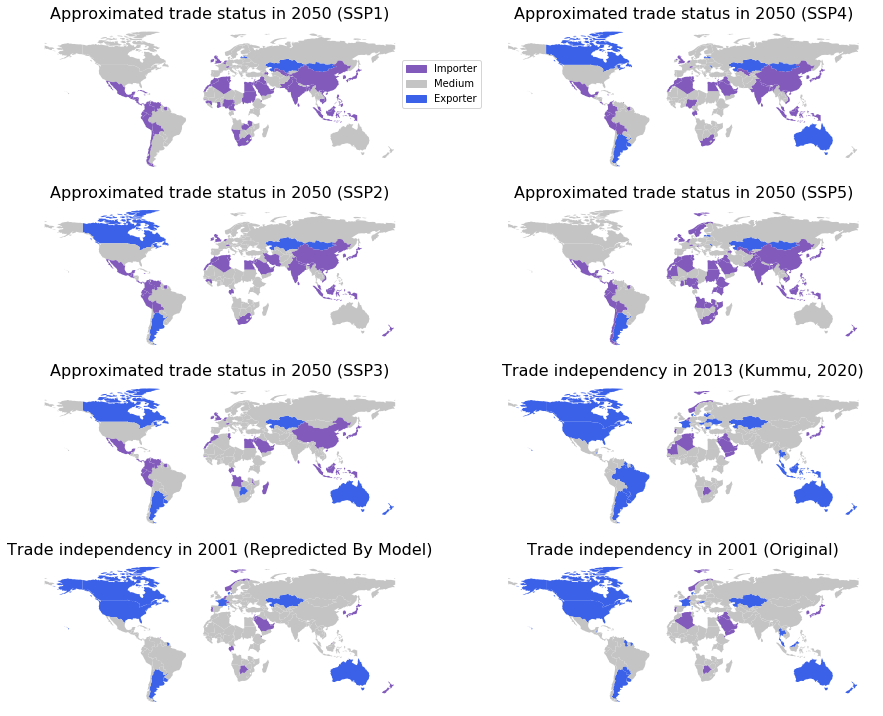

In [7]:
randForClass_2001()

In [8]:
df

,Calsuff_2000,Calsuff_ssp1,Calsuff_ssp2,Calsuff_ssp3,Calsuff_ssp4,Calsuff_ssp5,trade_dep_2013,GDP_2010,GDP_ssp1,GDP_ssp2,...,log_GDP_ssp2,log_GDP_ssp3,log_GDP_ssp4,log_GDP_ssp5,Trade_lm_predicted_ssp1,Trade_lm_predicted_ssp2,Trade_lm_predicted_ssp3,Trade_lm_predicted_ssp4,Trade_lm_predicted_ssp5,Repredicted_2001
ISO3,,,,,,,,,,,,,,,,,,,,,
AFG,0.785233,0.357539,0.302060,0.285515,0.265726,0.462921,0.269311,1.185439,7.525939,4.182579,...,1.430928,1.061724,0.961908,2.259554,Medium,Medium,Medium,Medium,Medium,Medium
AGO,0.597733,0.308747,0.397758,0.200725,0.310365,0.433238,0.221301,5.171680,12.157659,7.386279,...,1.999624,1.607744,1.883289,2.843462,Medium,Medium,Importer,Medium,Importer,Medium
ALB,2.319537,2.144321,2.112085,1.997762,2.156844,2.172469,0.208123,7.660737,23.061599,18.183380,...,2.900508,2.645800,2.930412,3.344888,Medium,Medium,Medium,Medium,Medium,Medium
ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0.000000,42.351171,79.490116,71.008454,...,4.262799,4.196524,4.409049,4.611188,Importer,Importer,Importer,Importer,Importer,Importer
ARG,8.343864,5.579006,6.409942,6.254420,5.945893,6.103357,1.000000,14.362739,46.757355,38.709480,...,3.656085,3.327148,3.613551,4.040325,Medium,Exporter,Exporter,Exporter,Exporter,Exporter
ARM,1.734574,1.798140,1.967693,1.696076,1.924673,2.131634,0.124763,4.900712,23.176016,16.818042,...,2.822452,2.534586,2.895610,3.367218,Medium,Medium,Medium,Medium,Medium,Medium
AUS,11.085546,5.154391,5.066072,8.800898,6.656228,4.108241,1.000000,35.727861,66.798098,59.149557,...,4.080069,4.003397,4.238384,4.342543,Medium,Medium,Exporter,Exporter,Medium,Exporter
AUT,2.824697,2.560388,2.677088,2.420327,2.609182,2.175140,0.326643,35.364546,62.057954,60.917517,...,4.109521,4.022241,4.170904,4.261119,Medium,Medium,Medium,Medium,Medium,Medium
AZE,2.154729,1.735103,1.762769,1.698961,1.728537,1.753897,0.221751,8.782760,17.689485,14.131447,...,2.648403,2.417148,2.733016,3.108171,Importer,Medium,Medium,Medium,Importer,Medium


In [9]:
temp = df[['2001_Trade_Class','Repredicted_2001', 'name']]
errors = []
error_classes = []

for ind in range(len(temp)):
    if temp['2001_Trade_Class'][ind] != temp['Repredicted_2001'][ind]:
        errors.append(temp['name'][ind])
        error_classes.append(temp['2001_Trade_Class'][ind])
print(len(errors), "countries were incorrectly predicted by the model on the 2001 data(which it was trained on)", errors);
print("Correct Classes of Countries", error_classes);
print()

temp = df[['Trade_lm_predicted_ssp1', 'Trade_lm_predicted_ssp2', 'Trade_lm_predicted_ssp3','Trade_lm_predicted_ssp4','Trade_lm_predicted_ssp5','Trade_2013','GDP_ssp1','GDP_ssp2','GDP_ssp3','GDP_ssp4','GDP_ssp5','name']]
predicted_2013= temp.copy()

## Importer-Exporter Analysis

15 countries were incorrectly predicted by the model on the 2001 data(which it was trained on) ['Belize', 'Switzerland', 'Dominican Republic', 'Algeria', 'Gabon', 'Guyana', 'Hungary', 'Iraq', 'Malaysia', 'New Zealand', 'Paraguay', 'Slovenia', 'Swaziland', 'Thailand', 'Yemen']
Correct Classes of Countries ['Exporter', 'Medium', 'Importer', 'Importer', 'Medium', 'Exporter', 'Exporter', 'Importer', 'Exporter', 'Exporter', 'Exporter', 'Importer', 'Exporter', 'Exporter', 'Importer']



### Within the countries exporters in 2013, how many remain exporters in 2050?

In [22]:
#xx remain exporters under all scenarios
remain_exp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == "Exporter" and predicted_2013['Trade_lm_predicted_ssp2'][ind] == "Exporter" and predicted_2013['Trade_lm_predicted_ssp3'][ind] == "Exporter" and predicted_2013['Trade_lm_predicted_ssp4'][ind] == "Exporter" and predicted_2013['Trade_lm_predicted_ssp5'][ind] == "Exporter" and df['2013_Trade_Class'][ind] == "Exporter":
        remain_exp.append(predicted_2013['name'][ind])
print(len(remain_exp), " countries remain exporters from 2013 to 2050 in all SSPs", remain_exp);
print()

#xx remain exporters only in some scenarios
remain_exp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == "Exporter" and df['2013_Trade_Class'][ind] == "Exporter":
        remain_exp1.append(predicted_2013['name'][ind])
print(len(remain_exp1), " countries remain exporters from 2013 to 2050 in SSP1", remain_exp1);
print()

remain_exp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] == "Exporter" and df['2013_Trade_Class'][ind] == "Exporter":
        remain_exp2.append(predicted_2013['name'][ind])
print(len(remain_exp2), " countries remain exporters from 2013 to 2050 in SSP2", remain_exp2);
print()

remain_exp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == "Exporter" and df['2013_Trade_Class'][ind] == "Exporter":
        remain_exp3.append(predicted_2013['name'][ind])
print(len(remain_exp3), " countries remain exporters from 2013 to 2050 in SSP3", remain_exp3);
print()

remain_exp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] == "Exporter" and df['2013_Trade_Class'][ind] == "Exporter":
        remain_exp4.append(predicted_2013['name'][ind])
print(len(remain_exp4), " countries remain exporters from 2013 to 2050 in SSP4", remain_exp4);
print()

remain_exp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] == "Exporter" and df['2013_Trade_Class'][ind] == "Exporter":
        remain_exp5.append(predicted_2013['name'][ind])
print(len(remain_exp5), " countries remain exporters from 2013 to 2050 in SSP5", remain_exp5);
print()

#xx NOT remain exporters under all scenarios
remain_exp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] != "Exporter" and predicted_2013['Trade_lm_predicted_ssp2'][ind] != "Exporter" and predicted_2013['Trade_lm_predicted_ssp3'][ind] != "Exporter" and predicted_2013['Trade_lm_predicted_ssp4'][ind] != "Exporter" and predicted_2013['Trade_lm_predicted_ssp5'][ind] != "Exporter" and df['2013_Trade_Class'][ind] == "Exporter":
        remain_exp.append(predicted_2013['name'][ind])
print(len(remain_exp), " countries do not remain exporters from 2013 to 2050 in all SSPs", remain_exp);
print()

#xx NOT remain exporters only in some scenarios
remain_exp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] != "Exporter" and df['2013_Trade_Class'][ind] == "Exporter":
        remain_exp1.append(predicted_2013['name'][ind])
print(len(remain_exp1), " countries do not remain exporters from 2013 to 2050 in SSP1", remain_exp1);
print()

remain_exp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] != "Exporter" and df['2013_Trade_Class'][ind] == "Exporter":
        remain_exp2.append(predicted_2013['name'][ind])
print(len(remain_exp2), " countries do not remain exporters from 2013 to 2050 in SSP2", remain_exp2);
print()

remain_exp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] != "Exporter" and df['2013_Trade_Class'][ind] == "Exporter":
        remain_exp3.append(predicted_2013['name'][ind])
print(len(remain_exp3), "countries do not remain exporters from 2013 to 2050 in SSP3", remain_exp3);
print()

remain_exp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] != "Exporter" and df['2013_Trade_Class'][ind] == "Exporter":
        remain_exp4.append(predicted_2013['name'][ind])
print(len(remain_exp4), "countries do not remain exporters from 2013 to 2050 in SSP4", remain_exp4);
print()

remain_exp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] != "Exporter" and df['2013_Trade_Class'][ind] == "Exporter":
        remain_exp5.append(predicted_2013['name'][ind])
print(len(remain_exp5), "countries do not remain exporters from 2013 to 2050 in SSP5", remain_exp5);
print()

#xx become new exporters
new_exp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == "Exporter" and predicted_2013['Trade_lm_predicted_ssp2'][ind] == "Exporter" and predicted_2013['Trade_lm_predicted_ssp3'][ind] == "Exporter" and predicted_2013['Trade_lm_predicted_ssp4'][ind] == "Exporter" and predicted_2013['Trade_lm_predicted_ssp5'][ind] == "Exporter" and df['2013_Trade_Class'][ind] != "Exporter":        
        new_exp.append(predicted_2013['name'][ind])
print(len(new_exp), " countries become new exporters from 2013 to 2050 in all SSPs", new_exp);
print()

#xx become exporters only in some scenarios
new_exp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == "Exporter" and df['2013_Trade_Class'][ind] != "Exporter":
        new_exp1.append(predicted_2013['name'][ind])
print(len(new_exp1), " countries become new exporters from 2013 to 2050 in SSP1", new_exp1);
print()

new_exp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] == "Exporter" and df['2013_Trade_Class'][ind] != "Exporter":
        new_exp2.append(predicted_2013['name'][ind])
print(len(new_exp2), " countries become new exporters from 2013 to 2050 in SSP2", new_exp2);
print()

new_exp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == "Exporter" and df['2013_Trade_Class'][ind] != "Exporter":
        new_exp3.append(predicted_2013['name'][ind])
print(len(new_exp3), " countries become new exporters from 2013 to 2050 in SSP3", new_exp3);
print()

new_exp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] == "Exporter" and df['2013_Trade_Class'][ind] != "Exporter":
        new_exp4.append(predicted_2013['name'][ind])
print(len(new_exp4), " countries become new exporters from 2013 to 2050 in SSP4", new_exp4);
print()

new_exp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] == "Exporter" and df['2013_Trade_Class'][ind] != "Exporter":
        new_exp5.append(predicted_2013['name'][ind])
print(len(new_exp5), " countries become new exporters from 2013 to 2050 in SSP5", new_exp5);
print()

0  countries remain exporters from 2013 to 2050 in all SSPs []

0  countries remain exporters from 2013 to 2050 in SSP1 []

0  countries remain exporters from 2013 to 2050 in SSP2 []

0  countries remain exporters from 2013 to 2050 in SSP3 []

0  countries remain exporters from 2013 to 2050 in SSP4 []

0  countries remain exporters from 2013 to 2050 in SSP5 []

21  countries do not remain exporters from 2013 to 2050 in all SSPs ['Argentina', 'Australia', 'Bulgaria', 'Belize', 'Brazil', 'Canada', 'Denmark', 'France', 'Guyana', 'Hungary', 'Indonesia', 'Kazakhstan', 'Lithuania', 'Latvia', 'Malaysia', 'New Zealand', 'Paraguay', 'Thailand', 'Ukraine', 'Uruguay', 'United States of America']

21  countries do not remain exporters from 2013 to 2050 in SSP1 ['Argentina', 'Australia', 'Bulgaria', 'Belize', 'Brazil', 'Canada', 'Denmark', 'France', 'Guyana', 'Hungary', 'Indonesia', 'Kazakhstan', 'Lithuania', 'Latvia', 'Malaysia', 'New Zealand', 'Paraguay', 'Thailand', 'Ukraine', 'Uruguay', 'United

### Within the countries importers in 2013, how many remain importers in 2050?

In [11]:
#xx remain importers under all scenarios
remain_imp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == "Importer" and predicted_2013['Trade_lm_predicted_ssp2'][ind] == "Importer" and predicted_2013['Trade_lm_predicted_ssp3'][ind] == "Importer" and predicted_2013['Trade_lm_predicted_ssp4'][ind] == "Importer" and predicted_2013['Trade_lm_predicted_ssp5'][ind] == "Importer" and df['2013_Trade_Class'][ind] == "Importer":
        remain_imp.append(predicted_2013['name'][ind])
print(len(remain_imp), " countries remain importers from 2013 to 2050 in all SSPs", remain_imp);
print()

#xx remain importers only in some scenarios
remain_imp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == "Importer" and df['2013_Trade_Class'][ind] == "Importer":
        remain_imp1.append(predicted_2013['name'][ind])
print(len(remain_imp1), " countries remain importers from 2013 to 2050 in SSP1", remain_imp1);
print()

remain_imp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] == "Importer" and df['2013_Trade_Class'][ind] == "Importer":
        remain_imp2.append(predicted_2013['name'][ind])
print(len(remain_imp2), " countries remain importers from 2013 to 2050 in SSP2", remain_imp2);
print()

remain_imp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == "Importer" and df['2013_Trade_Class'][ind] == "Importer":
        remain_imp3.append(predicted_2013['name'][ind])
print(len(remain_imp3), " countries remain importers from 2013 to 2050 in SSP3", remain_imp3);
print()

remain_imp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] == "Importer" and df['2013_Trade_Class'][ind] == "Importer":
        remain_imp4.append(predicted_2013['name'][ind])
print(len(remain_imp4), " countries remain importers from 2013 to 2050 in SSP4", remain_imp4);
print()

remain_imp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] == "Importer" and df['2013_Trade_Class'][ind] == "Importer":
        remain_imp5.append(predicted_2013['name'][ind])
print(len(remain_imp5), " countries remain importers from 2013 to 2050 in SSP5", remain_imp5);
print()

#xx NOT remain importers under all scenarios
remain_imp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] != "Importer" and predicted_2013['Trade_lm_predicted_ssp2'][ind] != "Importer" and predicted_2013['Trade_lm_predicted_ssp3'][ind] != "Importer" and predicted_2013['Trade_lm_predicted_ssp4'][ind] != "Importer" and predicted_2013['Trade_lm_predicted_ssp5'][ind] != "Importer" and df['2013_Trade_Class'][ind] == "Importer":
        remain_imp.append(predicted_2013['name'][ind])
print(len(remain_imp), " countries do not remain importers from 2013 to 2050 in all SSPs", remain_imp);
print()

#xx NOT remain importers only in some scenarios
remain_imp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] != "Importer" and df['2013_Trade_Class'][ind] == "Importer":
        remain_imp1.append(predicted_2013['name'][ind])
print(len(remain_imp1), " countries do not remain importers from 2013 to 2050 in SSP1", remain_imp1);
print()

remain_imp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] != "Importer" and df['2013_Trade_Class'][ind] == "Importer":
        remain_imp2.append(predicted_2013['name'][ind])
print(len(remain_imp2), " countries do not remain importers from 2013 to 2050 in SSP2", remain_imp2);
print()

remain_imp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] != "Importer" and df['2013_Trade_Class'][ind] == "Importer":
        remain_imp3.append(predicted_2013['name'][ind])
print(len(remain_imp3), "countries do not remain importers from 2013 to 2050 in SSP3", remain_imp3);
print()

remain_imp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] != "Importer" and df['2013_Trade_Class'][ind] == "Importer":
        remain_imp4.append(predicted_2013['name'][ind])
print(len(remain_imp4), "countries remain importers from 2013 to 2050 in SSP4", remain_imp4);
print()

remain_imp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] != "Importer" and df['2013_Trade_Class'][ind] == "Importer":
        remain_imp5.append(predicted_2013['name'][ind])
print(len(remain_imp5), "countries do not remain importers from 2013 to 2050 in SSP5", remain_imp5);
print()

#xx become new importers
new_imp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == "Importer" and predicted_2013['Trade_lm_predicted_ssp2'][ind] == "Importer" and predicted_2013['Trade_lm_predicted_ssp3'][ind] == "Importer" and predicted_2013['Trade_lm_predicted_ssp4'][ind] == "Importer" and predicted_2013['Trade_lm_predicted_ssp5'][ind] == "Importer" and df['2013_Trade_Class'][ind] != "Importer":        
        new_imp.append(predicted_2013['name'][ind])
print(len(new_imp), " countries become new importers from 2013 to 2050 in all SSPs", new_imp);
print()

#xx become importers only in some scenarios
new_imp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == "Importer" and df['2013_Trade_Class'][ind] != "Importer":
        new_imp1.append(predicted_2013['name'][ind])
print(len(new_imp1), " countries become new importers from 2013 to 2050 in SSP1", new_imp1);
print()

new_imp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] == "Importer" and df['2013_Trade_Class'][ind] != "Importer":
        new_imp2.append(predicted_2013['name'][ind])
print(len(new_imp2), " countries become new importers from 2013 to 2050 in SSP2", new_imp2);
print()

new_imp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == "Importer" and df['2013_Trade_Class'][ind] != "Importer":
        new_imp3.append(predicted_2013['name'][ind])
print(len(new_imp3), " countries become new importers from 2013 to 2050 in SSP3", new_imp3);
print()

new_imp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] == "Importer" and df['2013_Trade_Class'][ind] != "Importer":
        new_imp4.append(predicted_2013['name'][ind])
print(len(new_imp4), " countries become new importers from 2013 to 2050 in SSP4", new_imp4);
print()

new_imp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] == "Importer" and df['2013_Trade_Class'][ind] != "Importer":
        new_imp5.append(predicted_2013['name'][ind])
print(len(new_imp5), " countries become new importers from 2013 to 2050 in SSP5", new_imp5);
print()


13  countries remain importers from 2013 to 2050 in all SSPs ['United Arab Emirates', 'Brunei', 'Cyprus', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait', 'Lebanon', 'Netherlands', 'Saudi Arabia', 'Trinidad and Tobago', 'Tunisia']

18  countries remain importers from 2013 to 2050 in SSP1 ['United Arab Emirates', 'Belgium', 'Brunei', 'Cyprus', 'Djibouti', 'Algeria', 'Gambia', 'Iraq', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait', 'Lebanon', 'Netherlands', 'Saudi Arabia', 'Trinidad and Tobago', 'Tunisia']

14  countries remain importers from 2013 to 2050 in SSP2 ['United Arab Emirates', 'Brunei', 'Cyprus', 'Algeria', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait', 'Lebanon', 'Netherlands', 'Saudi Arabia', 'Trinidad and Tobago', 'Tunisia']

15  countries remain importers from 2013 to 2050 in SSP3 ['United Arab Emirates', 'Belgium', 'Brunei', 'Cyprus', 'Gambia', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait', 'Lebanon', 'Netherlands', 'Saudi Arabia', 'Trinidad and T

# Linear Regression Tests

In [126]:
def lin_reg(trade_out, comp_map_name):
    X = df[['Calsuff_2000','log_GDP_2010']]  
    y = df[[trade_out,'name','2001_Trade_Class']] 
    #print(y)
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state = 0)
    y_train_acc = y_train
    y_train = y_train_acc[trade_out]
    y_test_acc = y_test
    y_test = y_test_acc[trade_out]
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train)
    
    #Training Accuracy
    y_pred_train= regressor.predict(X_train)  
    y_p_tr_class = pd.DataFrame(np.nan, index = np.arange(len(y_pred_train)), columns = ['name1','class'])
    b = [None] * len(y_pred_train)
    for ind in range(len(y_pred_train)):
        if y_pred_train[ind] < 0.1:
            b[ind] = "Importer"
        elif y_pred_train[ind] > 0.8:
            b[ind] = "Exporter"
        else:
             b[ind] = "Medium"
    y_p_tr_class['class'] = b
    y_p_tr_class['name1'] = y_train_acc['name'].values
    count = 0
    for ind in range(len(y_p_tr_class)):
        if y_p_tr_class['class'][ind] == y_train_acc['2001_Trade_Class'][ind]:
            count = count+1
    t_acc = count/len(y_p_tr_class)            
    print("Training Accuracy:", t_acc)
    
    #Test Accuracy
    y_pred= regressor.predict(X_test)  
    y_p_te_class = pd.DataFrame(np.nan, index = np.arange(len(y_pred)), columns = ['name1','class'])
    b = [None] * len(y_pred)
    for ind in range(len(y_pred)):
        if y_pred[ind] < 0.1:
            b[ind] = "Importer"
        elif y_pred[ind] > 0.8:
            b[ind] = "Exporter"
        else:
             b[ind] = "Medium"
    y_p_te_class['class'] = b
    y_p_te_class['name1'] = y_test_acc['name'].values
    count = 0
    for ind in range(len(y_p_te_class)):
        if y_p_te_class['class'][ind] == y_test_acc['2001_Trade_Class'][ind]:
            count = count+1
    acc = count/len(y_p_te_class)            
    print("Test Accuracy:", acc)
    
    for i in np.arange(1,6):
        df['log_GDP_ssp'+str(i)] = df['GDP_ssp'+str(i)].apply(lambda x:np.log(x))
        
    for i in np.arange(1,6):
        df['Trade_lm_predicted_ssp'+str(i)] = regressor.predict(df[['Calsuff_ssp'+str(i),'log_GDP_ssp'+str(i)]])
        
    import geopandas
    import matplotlib.pyplot as plt
    import matplotlib.colors
    #import geoplot

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world.set_index("iso_a3").merge(df)
    
    # Colormap
    levels = [0, 0.2, 0.4, 0.6, 0.8, 0.99,1.01]
    colors = ['#dadaeb', '#9e9ac8', '#756bb1', '#54278f','#3f007d','black']
    cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)

    fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(20, 10))

    world.plot(column='Trade_lm_predicted_ssp1', cmap=cmap, norm=norm, linewidth=0.8, ax=axes[0,0])#, edgecolor=’0.8')
    axes[0,0].set_title('Approximated trade status in 2050 (SSP1)', fontdict={'fontsize':'16'});
    axes[0,0].axis('off');

    world.plot(column='Trade_lm_predicted_ssp2', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[1,0])#, edgecolor=’0.8')
    axes[1,0].set_title('Approximated trade status in 2050 (SSP2)', fontdict={'fontsize':'16'});
    axes[1,0].axis('off');

    world.plot(column='Trade_lm_predicted_ssp3', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[2,0])#, edgecolor=’0.8')
    axes[2,0].set_title('Approximated trade status in 2050 (SSP3)', fontdict={'fontsize':'16'});
    axes[2,0].axis('off');


    world.plot(column='Trade_lm_predicted_ssp4', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[0,1])#, edgecolor=’0.8')
    axes[0,1].set_title('Approximated trade status in 2050 (SSP4)', fontdict={'fontsize':'16'});
    axes[0,1].axis('off');

    world.plot(column='Trade_lm_predicted_ssp5', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[1,1])#, edgecolor=’0.8')
    axes[1,1].set_title('Approximated trade status in 2050 (SSP5)', fontdict={'fontsize':'16'});
    axes[1,1].axis('off');

    world.plot(column=trade_out, cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[2,1])#, edgecolor=’0.8')
    axes[2,1].set_title(comp_map_name, fontdict={'fontsize':'16'});
    axes[2,1].axis('off');
    
    fig.savefig('lin_reg_map', bbox_inches='tight')

## Compare 2050 Predictions(trained on 2001 trade index) with 2001 Trade Index

Training Accuracy: 0.78
Test Accuracy: 0.75


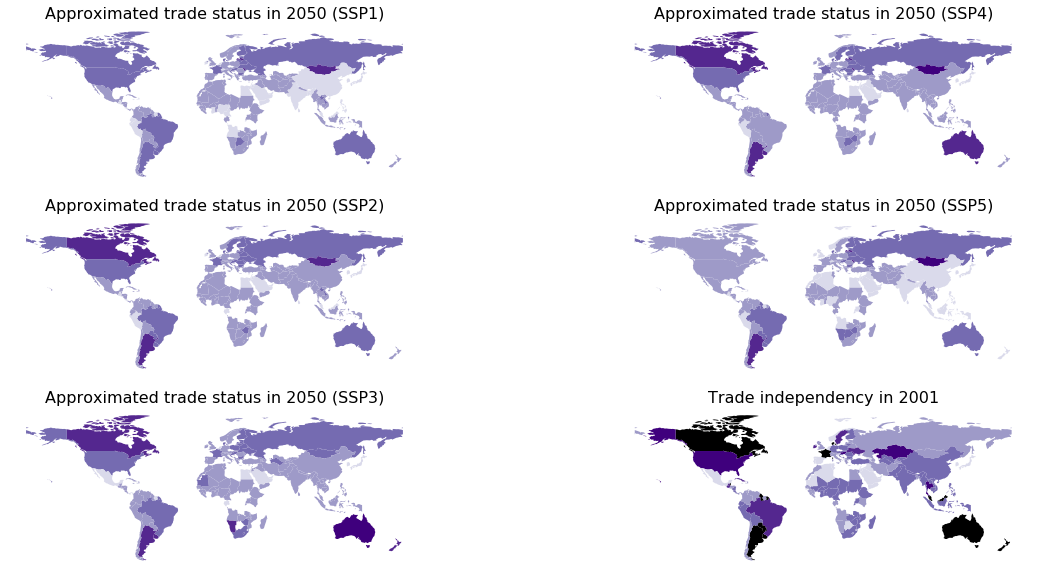

In [127]:
lin_reg('Trade_2001', 'Trade independency in 2001')

# Grayscale Sample of Map

In [20]:
import geopandas
import matplotlib.pyplot as plt
import matplotlib.colors
#import geoplot

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.set_index("iso_a3").merge(df)

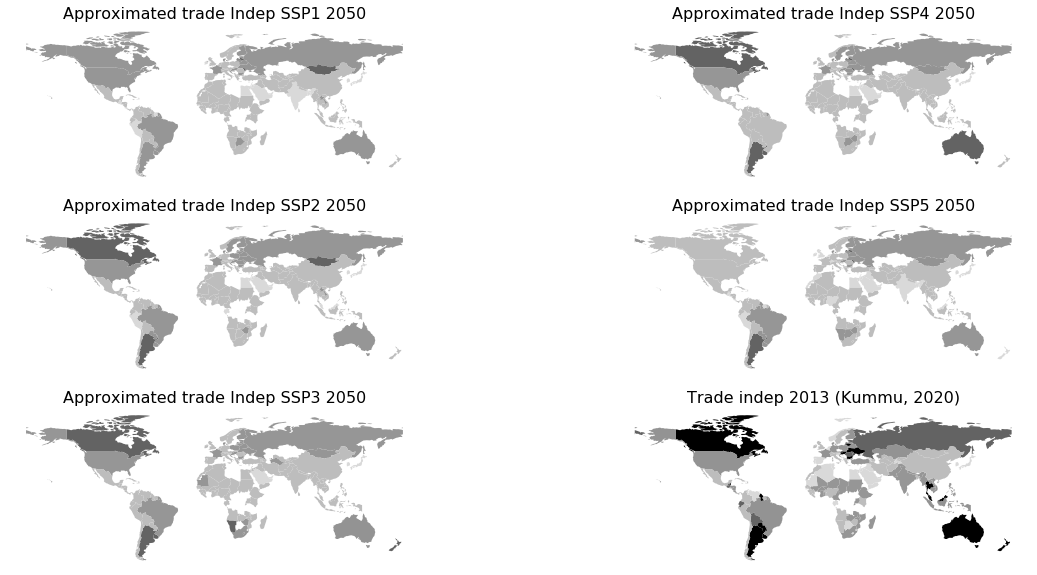

In [21]:
# Colormap
levels = [0, 0.2, 0.4, 0.6, 0.8, 0.99,1.01]
colors = ['#d9d9d9', '#bdbdbd', '#969696','#636363','252525','black']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)

# Map predicted Trade 2050 and Trade 2013.

fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(20, 10))

world.plot(column='Trade_lm_predicted_ssp1', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[0,0])#, edgecolor=’0.8')
axes[0,0].set_title('Approximated trade Indep SSP1 2050', fontdict={'fontsize':'16'});
axes[0,0].axis('off');

world.plot(column='Trade_lm_predicted_ssp2', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[1,0])#, edgecolor=’0.8')
axes[1,0].set_title('Approximated trade Indep SSP2 2050', fontdict={'fontsize':'16'});
axes[1,0].axis('off');

world.plot(column='Trade_lm_predicted_ssp3', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[2,0])#, edgecolor=’0.8')
axes[2,0].set_title('Approximated trade Indep SSP3 2050', fontdict={'fontsize':'16'});
axes[2,0].axis('off');


world.plot(column='Trade_lm_predicted_ssp4', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[0,1])#, edgecolor=’0.8')
axes[0,1].set_title('Approximated trade Indep SSP4 2050', fontdict={'fontsize':'16'});
axes[0,1].axis('off');

world.plot(column='Trade_lm_predicted_ssp5', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[1,1])#, edgecolor=’0.8')
axes[1,1].set_title('Approximated trade Indep SSP5 2050', fontdict={'fontsize':'16'});
axes[1,1].axis('off');

world.plot(column='Trade_2013', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[2,1])#, edgecolor=’0.8')
axes[2,1].set_title('Trade indep 2013 (Kummu, 2020)', fontdict={'fontsize':'16'});
axes[2,1].axis('off');